# **Context Specificity of Mesenchymal to Epithelial Transition** 

# Notebook Outline

1. [Libraries](#lib)
1. [Model upload](#model)
1. [Steady state analysis](#ss_analysis)
1. [EMT and MET - different input combinations](#emt_met)
    - [OVOL1 is crucial for MET induced by BMP](#ovol1)
1. [Autocrine signals maintains EMT](#auto)
1. [Mutation analysis](#mut_analysis)

<a id='lib'></a>
# Libraries

In [1]:
import maboss
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import maboss_test
from sklearn.decomposition import PCA

from my_functions_maboss_analysis import  my_pie_chart, multiple_mutations

In [2]:
#define path for results
path='./results/'
if not os.path.exists(path):
   os.makedirs(path)

<a id='model'></a>
# Model upload

In [3]:
# Model
model = maboss.load("./network.bnd", "./network.cfg")
param = {'max_time': 200, 'time_tick': 1, 'sample_count': 10000, 'thread_count':6, 'use_physrandgen':0}
model.param.update(param)
nodes = list(model.network.keys())

on = [0, 1]
off = [1, 0]
random = [0.5, 0.5]
high = [0.2,0.8]
low = [0.8,0.2]

In [61]:
#determine inputs, readouts, MET_drivers, EMT_drivers and internal nodes
inputs=["BMP", "GF", "TGFB_L"]
MET_drivers=["GRHL2", "P63", "miR200", "miR205", "OVOL1", "OVOL2"]
EMT_drivers=["TWIST", "SNAI1","SNAI2", "ZEB1", "ZEB2", "PRRX1", "BCAT_TCF"]
readouts=MET_drivers+EMT_drivers+["AdhJunc", "TightJunc" ,"NCAD", "VIM"]
phenotypes=["E", "M", "pEM", "Naive"]

int_nodes=nodes.copy()
to_remove=['E','pEM','M', 'Naive','TJ', 'VIM', 'NCAD', 'BMP7', 'TGFB_L', 'GF', 'M1', 'M2', 'E1', 'E2', 'pEM1', 'pEM2', 'pEM3']
for ele in to_remove:
    if ele in int_nodes:
        int_nodes.remove(ele)

<a id='ss_analysis'></a>
# Steady state analysis

The exact steady states can be found, but they can also be estimated. Here, we estimated them by simulating the time evolution of the system with random initial conditions. 

Steady states are classified into **Epithelial (E), Mesenchymal (M), partial Epithelial Mesenchymal (pEM) or Naive** phenotypes according to the activity of the epithelial and mesenchymal nodes. 

The model has 25 steady states
 Epithelial: 6 
 Mesenchymal: 8 
 Partial: 10 
 Naive: 1


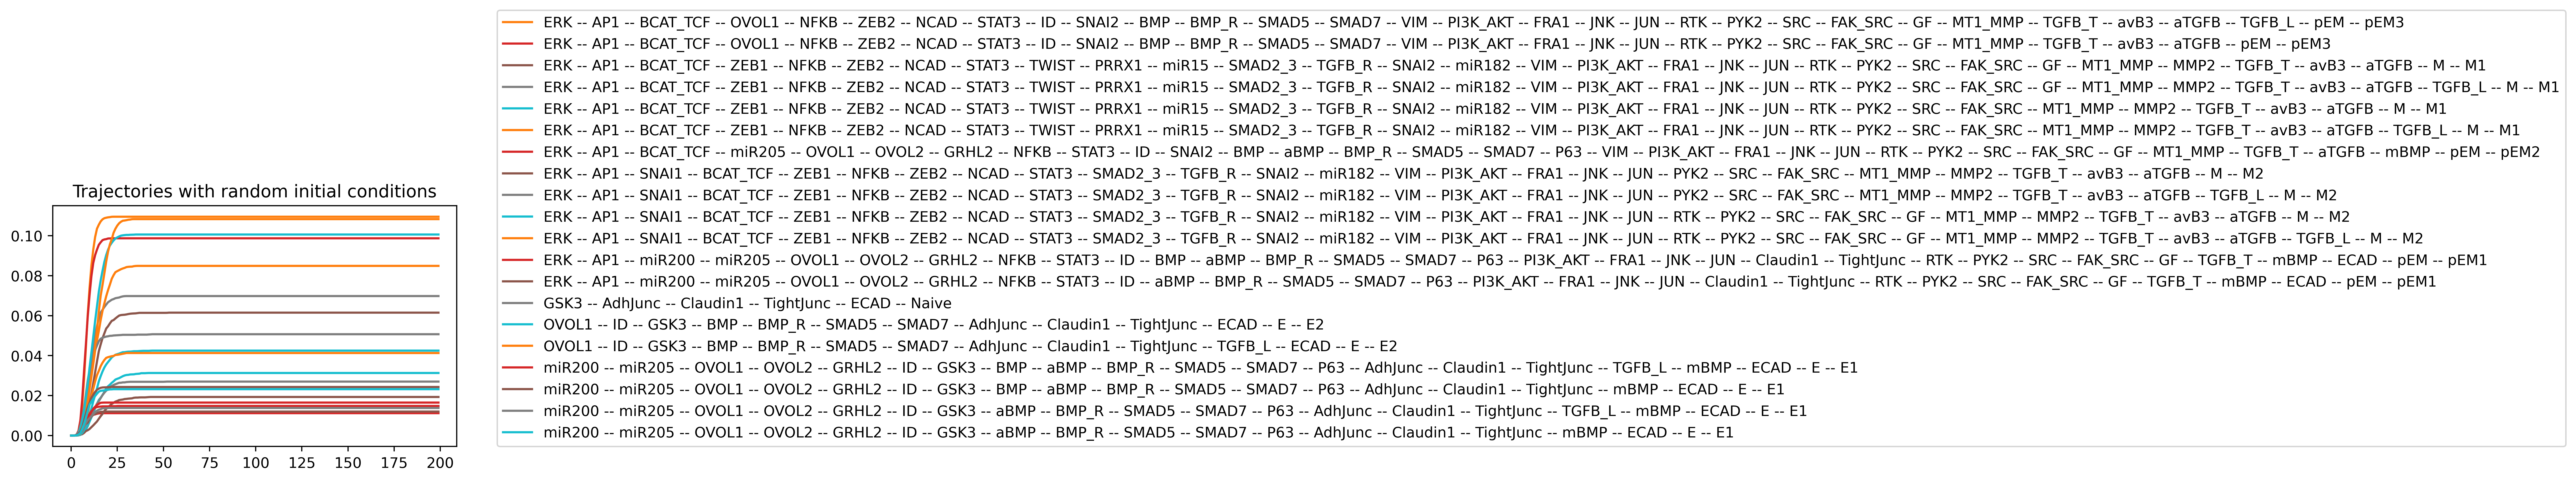

In [5]:
sim = model.copy()
maboss.set_nodes_istate(sim, nodes, random)
maboss.set_output(sim, nodes)
sim1 = sim.run()

fig = plt.figure(figsize=(5,3), dpi=500)
fig.subplots(1)
plt.title("Trajectories with random initial conditions")
sim1.plot_trajectory(axes=fig.axes[0])

steady_states=sim1.get_fptable()
print('The model has',len(steady_states), 'steady states\n',
    'Epithelial:', len(steady_states[steady_states["E"]==1]),'\n',
    'Mesenchymal:', len(steady_states[steady_states["M"]==1]),'\n',
   'Partial:', len(steady_states[steady_states["pEM"]==1]), '\n',
    'Naive:', len(steady_states[steady_states["Naive"]==1]) )

In [6]:
#Verify that the prob sum is ~1

sum(steady_states.Proba)

0.9999999999999999

<a id='emt_met'></a>
# EMT and MET - different input combinations

### Establishing epithelial inicial conditions (EpiIC)

To test EMT, we first establish initial conditions that would favor the cells to acquire an epithelial phenotype. This condition is termed **EpiIC** and corresponds to:
* MET-drivers high
* EMT- drivers low
* rest of the nodes at random probability to be active

In [7]:
i_condition_e = model.copy()
maboss.set_nodes_istate(i_condition_e , i_condition_e.network.keys(), random)
maboss.set_nodes_istate(i_condition_e, MET_drivers, high)
maboss.set_nodes_istate(i_condition_e, EMT_drivers, low)
maboss.set_output(i_condition_e, phenotypes)

### Input combination simulations on EpIC
Here, we explore how different input combinations will generate different phenotypes in EpiIC

In [8]:
# dictrionary of the possible input combinations
input_combinatons= {"[TGFB_L=0, BMP=0, GF=0]": {"TGFB_L":off, "BMP":off, "GF":off}, 
    "[TGFB_L=1, BMP=0, GF=0]": {"TGFB_L":on, "BMP":off, "GF":off}, 
         "[TGFB_L=0, BMP=1, GF=0]": {"TGFB_L":off, "BMP":on, "GF":off},
          "[TGFB_L=0, BMP=0, GF=1]": {"TGFB_L":off, "BMP":off, "GF":on},
           "[TGFB_L=1, BMP=1, GF=0]": {"TGFB_L":on, "BMP":on, "GF":off},
            "[TGFB_L=0, BMP=1, GF=1]": {"TGFB_L":off, "BMP":on, "GF":on},
             "[TGFB_L=1, BMP=0, GF=1]": {"TGFB_L":on, "BMP":off, "GF":on},
                "[TGFB_L=1, BMP=1, GF=1]": {"TGFB_L":on, "BMP":on, "GF":on}}

In [9]:
#dictionary of colors to plot pie charts from simulations (for the plots to be saved)
colors = {"M1": "#bd9ffa", 
          "M2":"#8f28ca", 
         "E1": "#99ccff",
         "E2": "#326496",
         "pEM1": "#ff9933",
         "pEM2": "#a83020",
         "pEM3": "#ffcf33", 
         "Naive": "#808080"}
colors_keys = list(colors.keys())

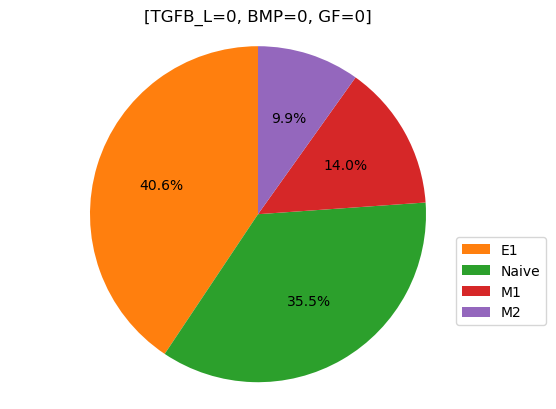

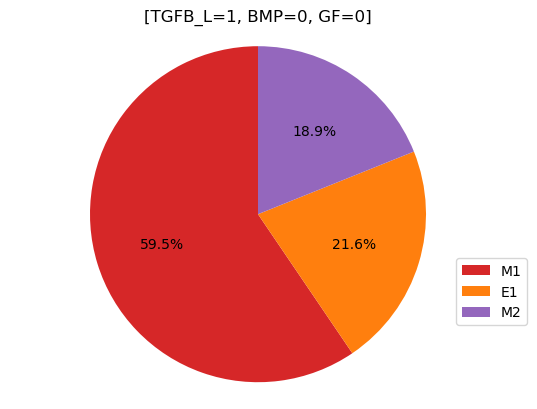

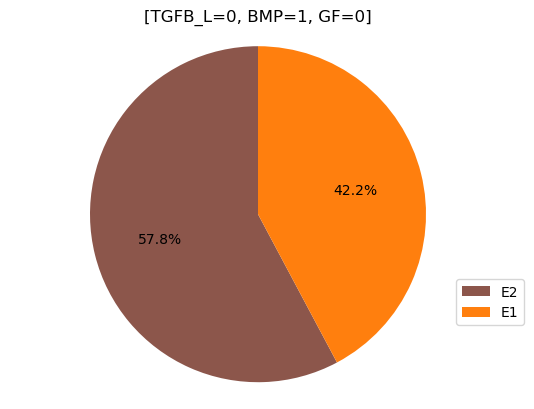

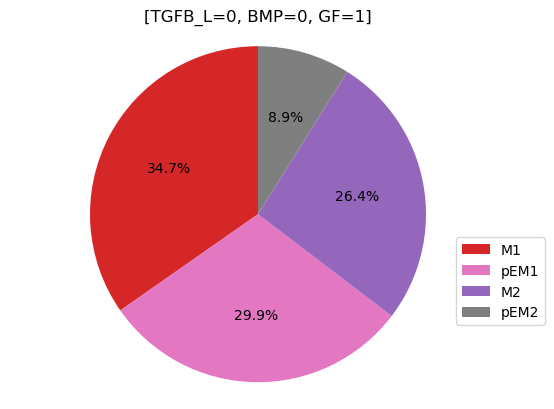

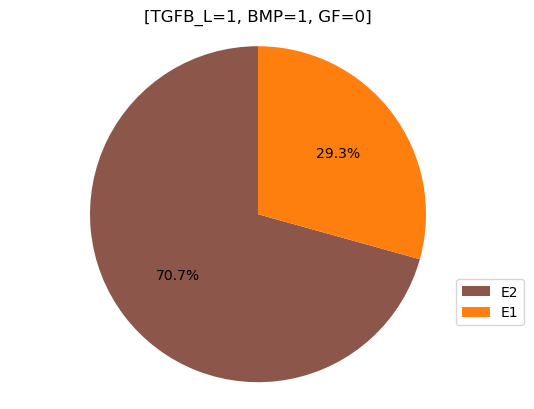

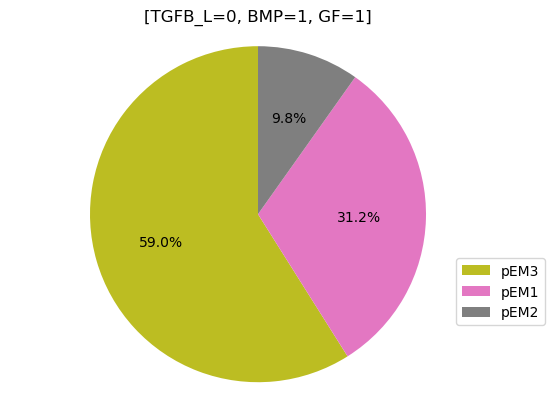

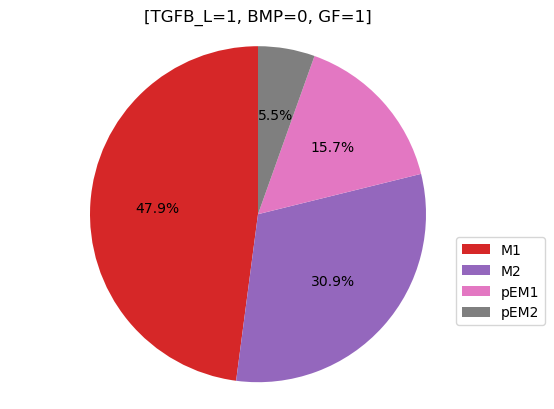

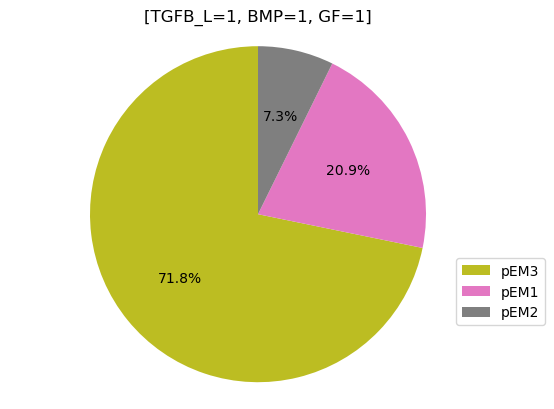

In [10]:
maboss.set_output(i_condition_e, ['M1', 'M2', 'E1', 'E2', 'pEM1', 'pEM2', 'pEM3', 'Naive'])
input_combinatons_keys = list(input_combinatons.keys())

for input_set in input_combinatons_keys:
    inner_dict= input_combinatons[input_set]

    for index, (key, value) in enumerate(inner_dict.items()):
        gene=key
        init_cond=value
        i_condition_e.network.set_istate(gene, init_cond)
    
    res = i_condition_e.run()
    res.plot_piechart()
    plt.title(input_set)
    color_plot=[]

    for phen in list(res.get_last_nodes_probtraj().columns):
        for col in colors_keys:
            if (phen == col):
                color_plot.append(colors[col])
                
    my_pie_chart(res, color_plot)   
    plt.title(f"{input_set}\nin EpIC")
    plt.savefig(f"{path}EpIC_{input_set}.png", bbox_inches='tight')
    plt.close()

### Establishing mesenchymal inicial conditions

To test MET, we first establish initial conditions that would favor the cells to acquire a mesenchymal phenotype. This condition is termed **MesIC** and corresponds to:
* MET-drivers OFF
* EMT- drivers ON
* rest of the nodes at random probability to be active

In [11]:
i_condition_m = model.copy()
maboss.set_nodes_istate(i_condition_m , i_condition_m.network.keys(), random)
maboss.set_nodes_istate(i_condition_m, MET_drivers, low)
maboss.set_nodes_istate(i_condition_m, EMT_drivers, high)
maboss.set_output(i_condition_m, phenotypes)

### Input combination simulations on MesIC
Here, we explore how different input combinations will generate different phenotypes in MesIC

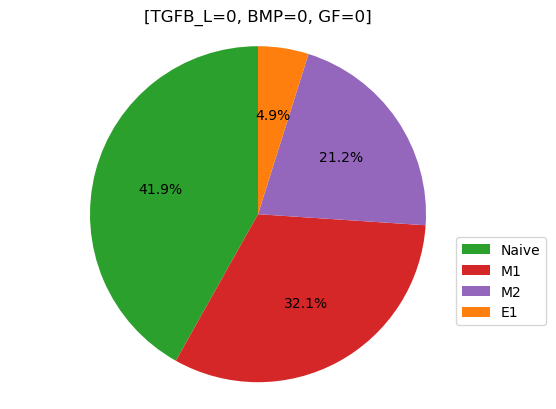

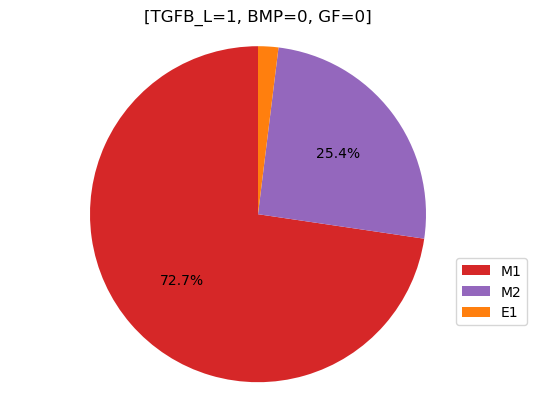

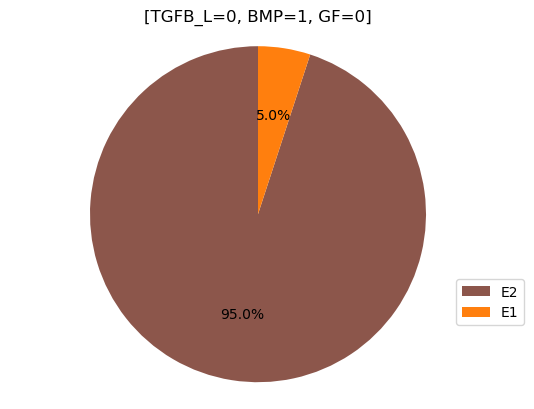

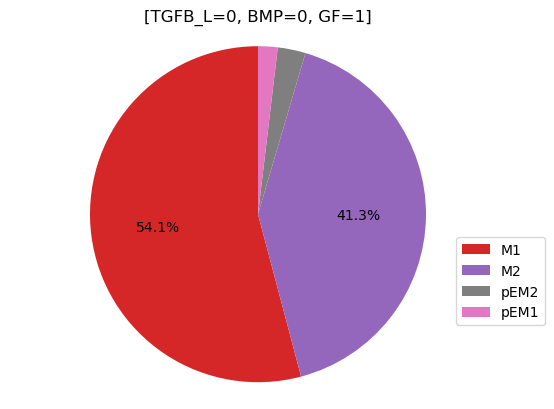

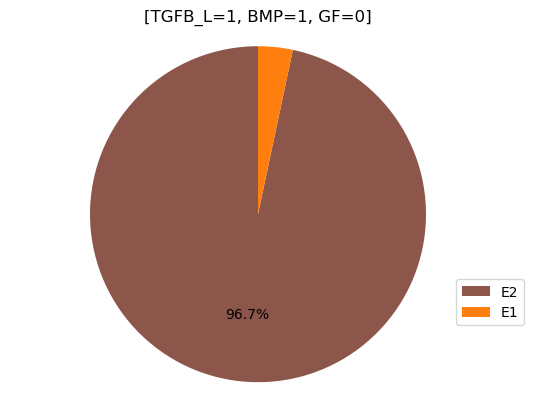

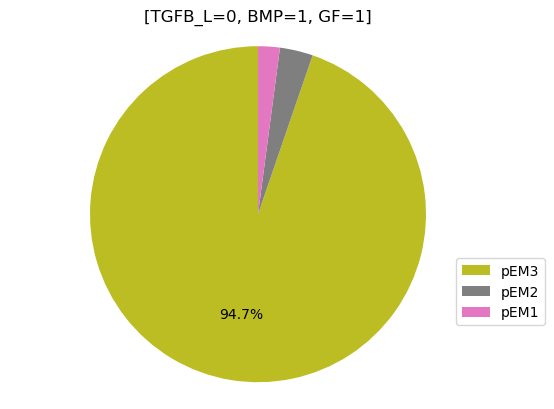

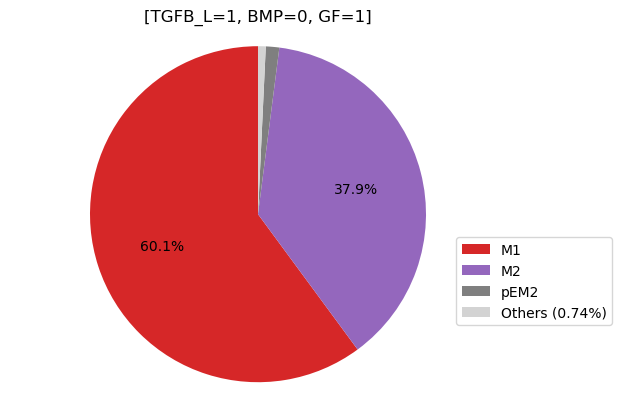

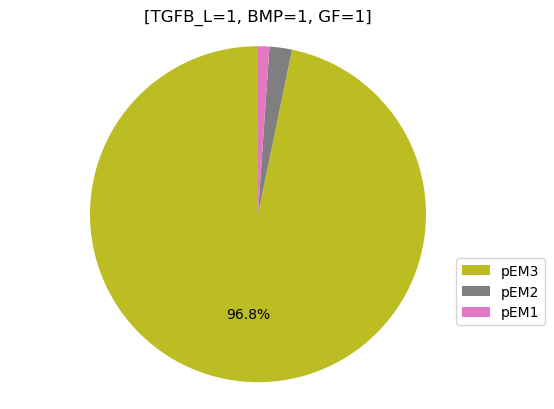

In [12]:
maboss.set_output(i_condition_m, ['M1', 'M2', 'E1', 'E2', 'pEM1', 'pEM2', 'pEM3', 'Naive'])
input_combinatons_keys = list(input_combinatons.keys())

for input_set in input_combinatons_keys:
    inner_dict= input_combinatons[input_set]

    for index, (key, value) in enumerate(inner_dict.items()):
        gene=key
        init_cond=value
        i_condition_m.network.set_istate(gene, init_cond)
    
    res = i_condition_m.run()
    res.plot_piechart()
    plt.title(input_set)
    color_plot=[]

    for phen in list(res.get_last_nodes_probtraj().columns):
        for col in colors_keys:
            if (phen == col):
                color_plot.append(colors[col])
                
    my_pie_chart(res, color_plot)   
    plt.title(f"{input_set}\nin MesIC")
    plt.savefig(f"{path}MesIC_{input_set}.png", bbox_inches='tight')
    plt.close()

<a id='ovol1'></a>
## OVOL1 is crucial for MET induced by BMP

To test if BMP would be able to induce MET without being able to activate OVOL1, we change the rule of OVOL1 such that it can no longer be activated by BMP

In [13]:
ovol1_modif = model.copy()

ovol1_modif.network['OVOL1'].set_logic('OVOL1')

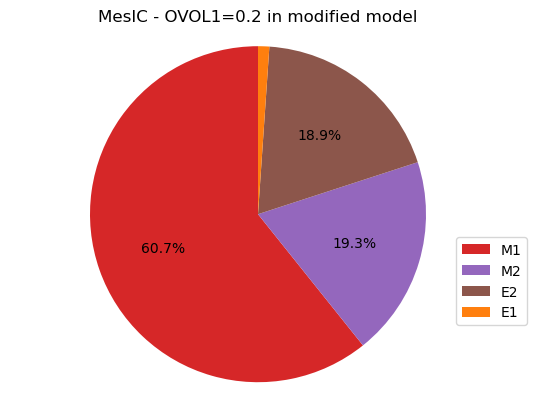

In [14]:
i_condition_m = ovol1_modif.copy()
maboss.set_nodes_istate(i_condition_m , i_condition_m.network.keys(), random)
maboss.set_nodes_istate(i_condition_m, MET_drivers, low)
maboss.set_nodes_istate(i_condition_m, EMT_drivers, high)
maboss.set_nodes_istate(i_condition_m, ["GF"], off)
maboss.set_nodes_istate(i_condition_m, ["BMP", "TGFB_L"], on)
maboss.set_output(i_condition_m, ['M1', 'M2', 'E1', 'E2', 'pEM1', 'pEM2', 'pEM3', 'Naive'])

res = i_condition_m.run()
res.plot_piechart()
plt.title("MesIC - OVOL1=0.2 in modified model")
#plt.savefig(f"{path}OVOL1_0.2.png", bbox_inches='tight')
#plt.close()

i_condition_m = ovol1_modif.copy()
maboss.set_nodes_istate(i_condition_m , i_condition_m.network.keys(), random)
maboss.set_nodes_istate(i_condition_m, MET_drivers, low)
maboss.set_nodes_istate(i_condition_m, EMT_drivers, high)
maboss.set_nodes_istate(i_condition_m, ["OVOL1"], off)
maboss.set_nodes_istate(i_condition_m, ["GF"], off)
maboss.set_nodes_istate(i_condition_m, ["BMP", "TGFB_L"], on)
maboss.set_output(i_condition_m, ['M1', 'M2', 'E1', 'E2', 'pEM1', 'pEM2', 'pEM3', 'Naive'])

res = i_condition_m.run()
res.plot_piechart()
plt.title("MesIC - OVOL1=0 in modified model")
plt.savefig(f"{path}OVOL1_0.png", bbox_inches='tight')
plt.close()

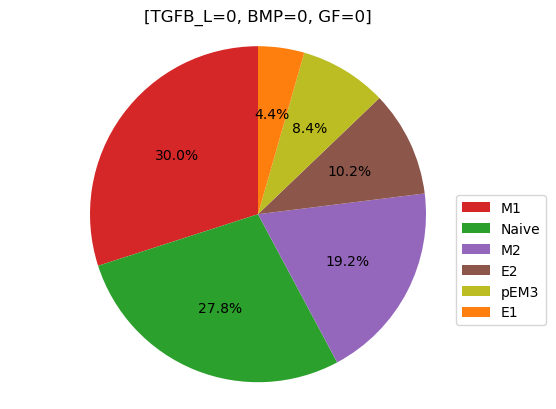

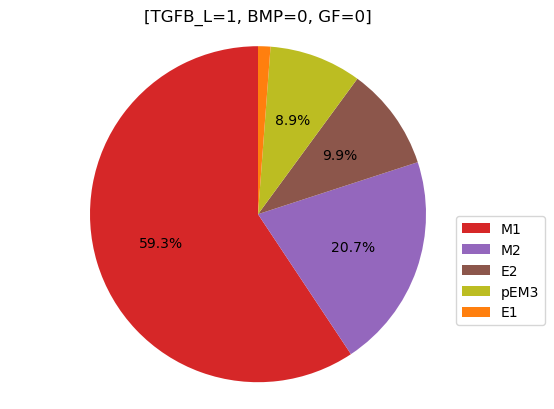

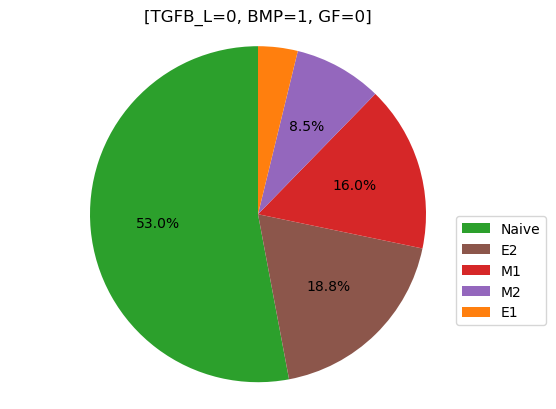

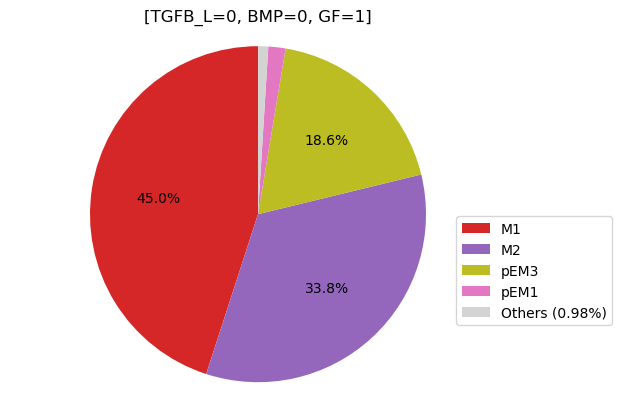

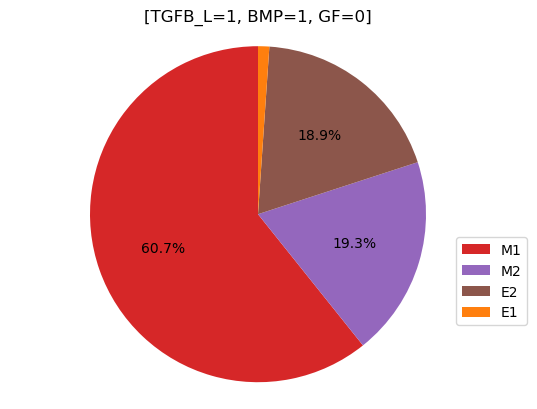

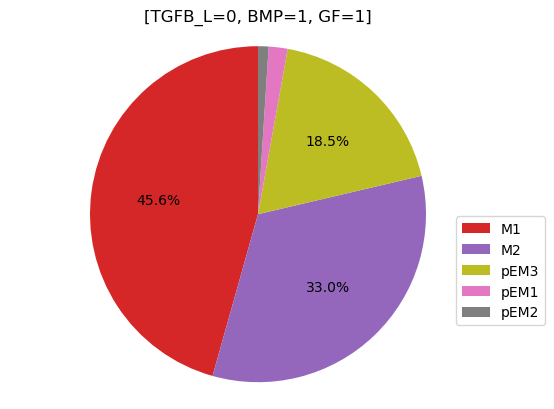

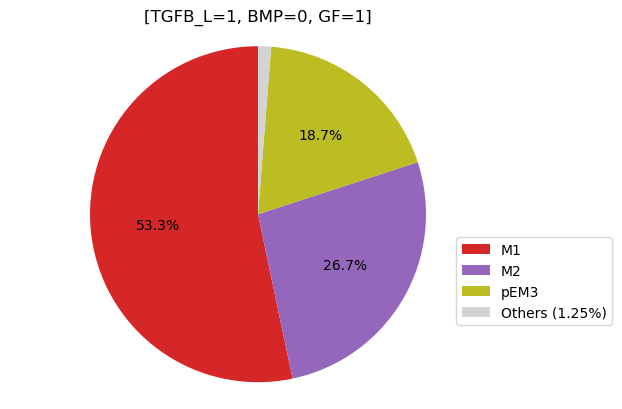

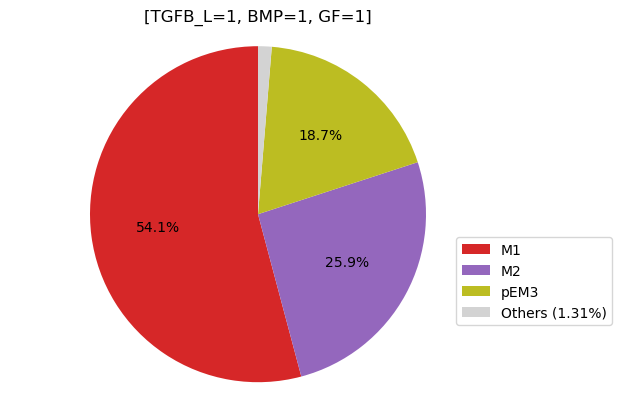

In [15]:
i_condition_m = ovol1_modif.copy()
maboss.set_nodes_istate(i_condition_m , i_condition_m.network.keys(), random)
maboss.set_nodes_istate(i_condition_m, MET_drivers, low)
maboss.set_nodes_istate(i_condition_m, EMT_drivers, high)
maboss.set_output(i_condition_m, ['M1', 'M2', 'E1', 'E2', 'pEM1', 'pEM2', 'pEM3', 'Naive'])

input_combinatons_keys = list(input_combinatons.keys())

for input_set in input_combinatons_keys:
    inner_dict= input_combinatons[input_set]

    for index, (key, value) in enumerate(inner_dict.items()):
        gene=key
        init_cond=value
        i_condition_m.network.set_istate(gene, init_cond)
    
    res = i_condition_m.run()
    res.plot_piechart()
    plt.title(input_set)
    color_plot=[]

    for phen in list(res.get_last_nodes_probtraj().columns):
        for col in colors_keys:
            if (phen == col):
                color_plot.append(colors[col])
                
    my_pie_chart(res, color_plot)   
    plt.title(f"{input_set}\nin MesIC - OVOL1 modified")
    plt.savefig(f"{path}OVOL1_modified_MesIC_{input_set}.png", bbox_inches='tight')
    plt.close()

<a id='auto'></a>
# Autocrine signals maintains EMT


Here, we explore how the EMT programs without inputs are generated. As there are two positive feedback loops (aTGFB) and TWITS activation of RTK, we make secondary models (modifications of the first model) to test how mutations will differentially affect these models. Thus we have three versions of the model:
1. The original model
2. model_aTGFB: where RTK receptor can only be activate by GF and not by TWIST. This is termed aTGFB as this feedback mechanism is still present.
3. model_RTK: where we changed the rule so that TGFBR can be activated only by the external input and not by aTGFB. This is termed aRTK as this feedback mechanism is still present.

On each model, we can test different mutations using maboss_test. This allows us to compare the probabilities of reaching the phenotypes between mutants and wild types

In [16]:
icondition_ep=MET_drivers
# Modified model for testing autocrine aRTK (no aTGFB) 
model_aRTK = model.copy()
model_aRTK.network['TGFB_R'].set_logic('(TGFB_L & !SMAD7)')

# Modified model for testing autocrine aTGFB (no aRTK)
model_aTGFB = model.copy()
model_aTGFB.network['RTK'].set_logic('(GF)')

model_aRTK.param.update(param)
model_aTGFB.param.update(param)

Test mutation effect in the original model

TWIST OFF decreases prob of Mesenchymal phenotype?
True!  
The new probability of reaching the state is: 0.0498 
The old one is: 0.3877

RTK OFF decreases prob of Mesenchymal phenotype?
True!  
The new probability of reaching the state is: 0.0466 
The old one is: 0.3877

aTGFB OFF decreases prob of Mesenchymal phenotype?
True!  
The new probability of reaching the state is: 0.2837 
The old one is: 0.3877

miR200 ON decreases prob of Mesenchymal phenotype?
True!  
The new probability of reaching the state is: 0 
The old one is: 0.3877

TGFB_R OFF decreases prob of Mesenchymal phenotype?
True!  
The new probability of reaching the state is: 0.2291 
The old one is: 0.3877

SRC OFF decreases prob of Mesenchymal phenotype?
True!  
The new probability of reaching the state is: 0.342 
The old one is: 0.3877

ZEB1 OFF + ZEB2 OFF decreases prob of Mesenchymal phenotype?
True!  
The new probability of reaching the state is: 0 
The old one is: 0.3877


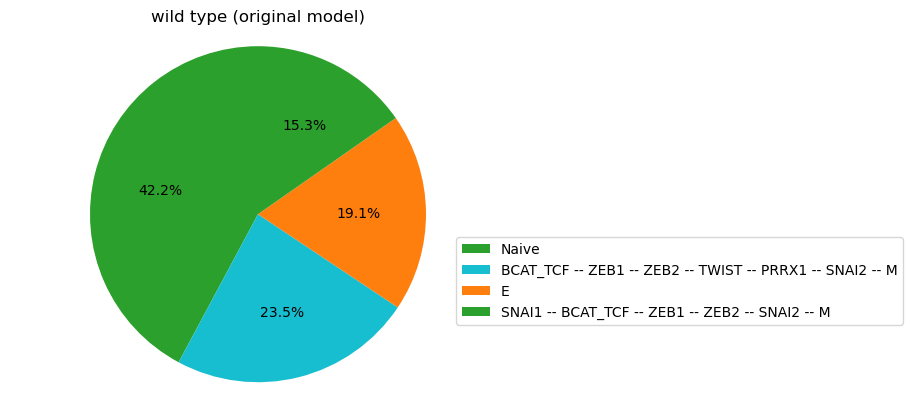

In [17]:
print("Test mutation effect in the original model\n")

i_condition = model.copy()
maboss.set_nodes_istate(i_condition , i_condition.network.keys(), random) #random nodes
maboss.set_nodes_istate(i_condition, ["BMP", "TGFB_L", "GF"], off) #inputs off
maboss.set_output(i_condition, phenotypes + EMT_drivers)
res = i_condition.run()
res.plot_piechart()
plt.title("wild type (original model)")

test_model = i_condition.copy()
init_condition = {"TGFB_L":[1, 0]} #TGFB OFF
run_test_model = maboss_test.MaBoSSTestCase(test_model)
print("TWIST OFF decreases prob of Mesenchymal phenotype?")
run_test_model.assertStateProbabilityEvolution({"TWIST":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\nRTK OFF decreases prob of Mesenchymal phenotype?")
run_test_model.assertStateProbabilityEvolution({"RTK":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\naTGFB OFF decreases prob of Mesenchymal phenotype?")
run_test_model.assertStateProbabilityEvolution({"aTGFB":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\nmiR200 ON decreases prob of Mesenchymal phenotype?")
run_test_model.assertStateProbabilityEvolution({"miR200":"ON"}, init_condition, {"M":1}, "decrease") 
print("\nTGFB_R OFF decreases prob of Mesenchymal phenotype?")
run_test_model.assertStateProbabilityEvolution({"TGFB_R":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\nSRC OFF decreases prob of Mesenchymal phenotype?")
run_test_model.assertStateProbabilityEvolution({"SRC":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\nZEB1 OFF + ZEB2 OFF decreases prob of Mesenchymal phenotype?")
run_test_model.assertStateProbabilityEvolution({"ZEB1":"OFF", "ZEB2":"OFF"}, init_condition, {"M":1}, "decrease") 

Test mutation effect in aRTK only model

TWIST OFF decreases prob of Mesenchymal phenotype in aRTK model?
True!  
The new probability of reaching the state is: 0 
The old one is: 0.2799

RTK OFF decreases prob of Mesenchymal phenotype in aRTK model?
True!  
The new probability of reaching the state is: 0 
The old one is: 0.2799

aTGFB OFF decreases prob of Mesenchymal phenotype in aRTK model?
False!  
The new probability of reaching the state is: 0.2837 
The old one is: 0.2799

miR200 ON decreases prob of Mesenchymal phenotype in aRTK model?
True!  
The new probability of reaching the state is: 0 
The old one is: 0.2799

TGFB_R OFF decreases prob of Mesenchymal phenotype in aRTK model?
True!  
The new probability of reaching the state is: 0.2291 
The old one is: 0.2799

SRC OFF decreases prob of Mesenchymal phenotype in aRTK model?
True!  
The new probability of reaching the state is: 0.2552 
The old one is: 0.2799

ZEB1 OFF + ZEB2 OFF decreases prob of Mesenchymal phenotype in aRTK mo

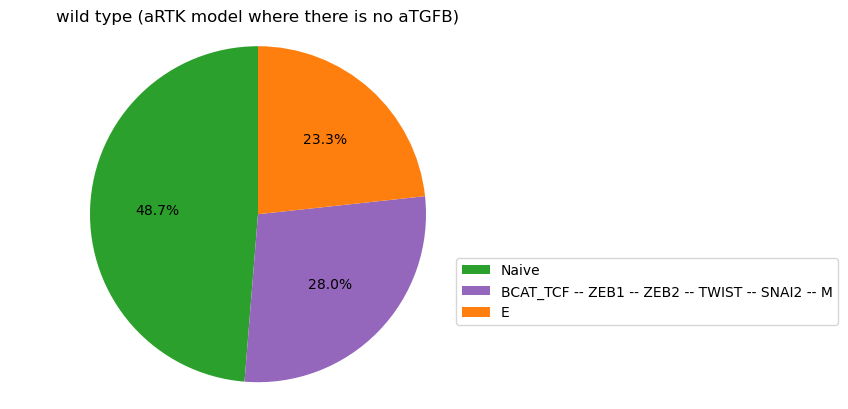

In [18]:
print("Test mutation effect in aRTK only model\n")

i_condition = model_aRTK.copy()
maboss.set_nodes_istate(i_condition , i_condition.network.keys(), random)
maboss.set_nodes_istate(i_condition, ["BMP", "TGFB_L", "GF"], off)
maboss.set_output(i_condition, phenotypes + EMT_drivers)
res = i_condition.run()
res.plot_piechart()
plt.title("wild type (aRTK model where there is no aTGFB)")

test_model = i_condition.copy()
init_condition = {"TGFB_L":[1, 0]} #TGFB OFF
run_test_model = maboss_test.MaBoSSTestCase(test_model)

print("TWIST OFF decreases prob of Mesenchymal phenotype in aRTK model?")
run_test_model.assertStateProbabilityEvolution({"TWIST":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\nRTK OFF decreases prob of Mesenchymal phenotype in aRTK model?")
run_test_model.assertStateProbabilityEvolution({"RTK":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\naTGFB OFF decreases prob of Mesenchymal phenotype in aRTK model?")
run_test_model.assertStateProbabilityEvolution({"aTGFB":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\nmiR200 ON decreases prob of Mesenchymal phenotype in aRTK model?")
run_test_model.assertStateProbabilityEvolution({"miR200":"ON"}, init_condition, {"M":1}, "decrease") 
print("\nTGFB_R OFF decreases prob of Mesenchymal phenotype in aRTK model?")
run_test_model.assertStateProbabilityEvolution({"TGFB_R":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\nSRC OFF decreases prob of Mesenchymal phenotype in aRTK model?")
run_test_model.assertStateProbabilityEvolution({"SRC":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\nZEB1 OFF + ZEB2 OFF decreases prob of Mesenchymal phenotype in aRTK model?")
run_test_model.assertStateProbabilityEvolution({"ZEB1":"OFF", "ZEB2":"OFF"}, init_condition, {"M":1}, "decrease") 

Test mutation effect in aTGFB only model

TWIST OFF decreases prob of Mesenchymal phenotype in aTGFB model?
True!  
The new probability of reaching the state is: 0.0498 
The old one is: 0.0535

RTK OFF decreases prob of Mesenchymal phenotype in aTGFB model?
True!  
The new probability of reaching the state is: 0.0466 
The old one is: 0.0535

aTGFB OFF decreases prob of Mesenchymal phenotype in aTGFB model?
True!  
The new probability of reaching the state is: 0 
The old one is: 0.0535

miR200 ON decreases prob of Mesenchymal phenotype in aTGFB model?
True!  
The new probability of reaching the state is: 0 
The old one is: 0.0535

TGFB_R OFF decreases prob of Mesenchymal phenotype in aTGFB model?
True!  
The new probability of reaching the state is: 0 
The old one is: 0.0535

SRC OFF decreases prob of Mesenchymal phenotype in aTGFB model?
True!  
The new probability of reaching the state is: 0 
The old one is: 0.0535

ZEB1 OFF + ZEB2 OFF decreases prob of Mesenchymal phenotype in aTGFB 

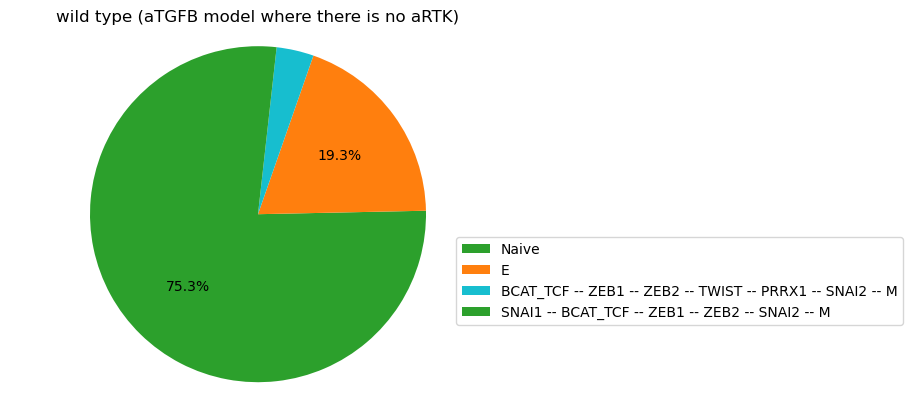

In [19]:
print("Test mutation effect in aTGFB only model\n")

i_condition = model_aTGFB.copy()
maboss.set_nodes_istate(i_condition , i_condition.network.keys(), random)
maboss.set_nodes_istate(i_condition, ["BMP", "TGFB_L", "GF"], off)
maboss.set_output(i_condition, phenotypes + EMT_drivers)
res = i_condition.run()
res.plot_piechart()
plt.title("wild type (aTGFB model where there is no aRTK)")

test_model = i_condition.copy()
init_condition = {"TGFB_L":[1, 0]} #TGFB OFF
run_test_model = maboss_test.MaBoSSTestCase(test_model)

print("TWIST OFF decreases prob of Mesenchymal phenotype in aTGFB model?")
run_test_model.assertStateProbabilityEvolution({"TWIST":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\nRTK OFF decreases prob of Mesenchymal phenotype in aTGFB model?")
run_test_model.assertStateProbabilityEvolution({"RTK":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\naTGFB OFF decreases prob of Mesenchymal phenotype in aTGFB model?")
run_test_model.assertStateProbabilityEvolution({"aTGFB":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\nmiR200 ON decreases prob of Mesenchymal phenotype in aTGFB model?")
run_test_model.assertStateProbabilityEvolution({"miR200":"ON"}, init_condition, {"M":1}, "decrease") 
print("\nTGFB_R OFF decreases prob of Mesenchymal phenotype in aTGFB model?")
run_test_model.assertStateProbabilityEvolution({"TGFB_R":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\nSRC OFF decreases prob of Mesenchymal phenotype in aTGFB model?")
run_test_model.assertStateProbabilityEvolution({"SRC":"OFF"}, init_condition, {"M":1}, "decrease") 
print("\nZEB1 OFF + ZEB2 OFF decreases prob of Mesenchymal phenotype in aTGFB model?")
run_test_model.assertStateProbabilityEvolution({"ZEB1":"OFF", "ZEB2":"OFF"}, init_condition, {"M":1}, "decrease") 

With the later simulations we see that most of them decrease the proportion of generated mesenchymal cells in all three models. However, some mutations can completely abolish the EMT program but this dependens on the model. We can explote the effect of single mutations on every node. The code for these results visualisation: emp_plots.R

In [20]:
all_intnodes_mut = {}
for node in int_nodes:
    all_intnodes_mut [node + " ON"] = {node : 'ON'}
    all_intnodes_mut [node + " OFF"] = {node : 'OFF'}

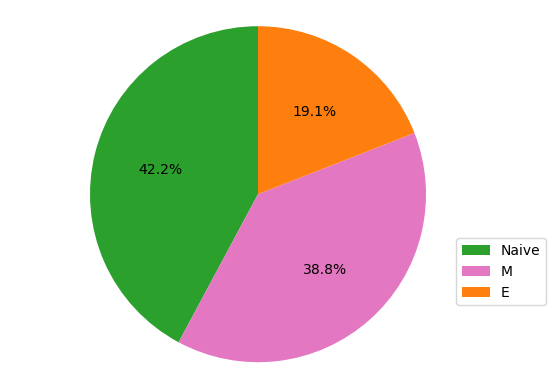

In [21]:
#define initial condition for orginial model
i_condition = model.copy()
maboss.set_nodes_istate(i_condition , i_condition.network.keys(), random)
i_condition.network.set_istate("TGFB_L", off)
i_condition.network.set_istate("GF", off)
i_condition.network.set_istate("BMP", off)
maboss.set_output(i_condition, phenotypes) 

df= multiple_mutations(i_condition, all_intnodes_mut, phenotypes)
df.to_csv('originalmodel_mutations_intnodes.txt', index=False) 

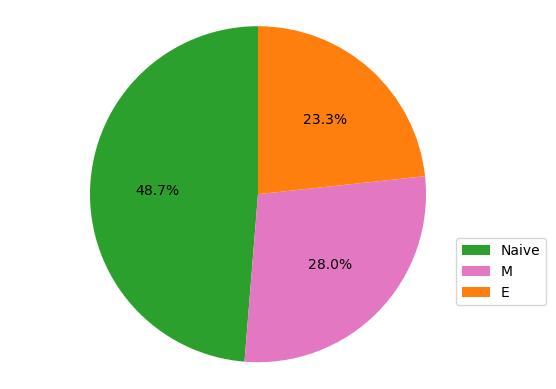

In [22]:
#define initial condition for model with no aTGFB, thus aRTK
i_condition = model_aRTK.copy()
maboss.set_nodes_istate(i_condition , i_condition.network.keys(), random)
i_condition.network.set_istate("TGFB_L", off)
i_condition.network.set_istate("GF", off)
i_condition.network.set_istate("BMP", off)
maboss.set_output(i_condition, phenotypes)

df= multiple_mutations(i_condition, all_intnodes_mut, phenotypes)
df.to_csv('modelaRTK_mutations_intnodes.txt', index=False) 

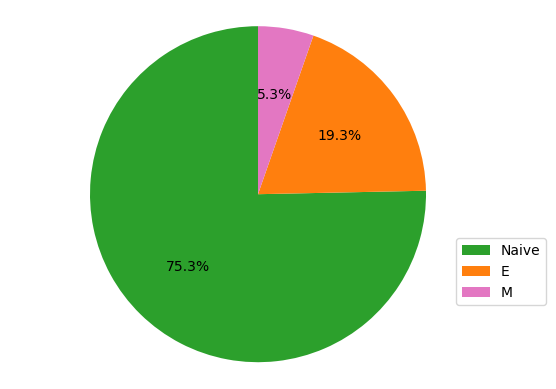

In [23]:
#define initial condition for model with no aRTK, thus aTGFB
i_condition = model_aTGFB.copy()
maboss.set_nodes_istate(i_condition , i_condition.network.keys(), random)
i_condition.network.set_istate("TGFB_L", off)
i_condition.network.set_istate("GF", off)
i_condition.network.set_istate("BMP", off)
maboss.set_output(i_condition, phenotypes)

df= multiple_mutations(i_condition, all_intnodes_mut, phenotypes)
df.to_csv('modelaTGFB_mutations_intnodes.txt', index=False) 

<a id='mut_analysis'></a>
# Mutation Analysis

The results are plotted in R with the scripts: emp_plots.R

We can make specific pertubations by forcing the expression or inhibition, under different conditions, of certain nodes and see how these affect the phenotypes.
The conditins that we will test are as follows:
1. Mesenchymal cells under TGFB_L:  EMT drivers ON, MET drivers OFF, TGFB_L ON, BMP7 OFF, GF OFF, rest of nodes random
2. Mesenchymal cells indenpendent of external TGFB_L:  EMT drivers ON, MET drivers OFF, TGFB_L OFF, BMP7 OFF, GF OFF, rest of nodes random
3. Epithelial cells cells under TGFB_L:  EMT drivers OFF, MET drivers ON, TGFB_L ON, BMP7 OFF, GF OFF, rest of nodes random
   
We can also simluate the effects of nodes not included in the network by interfering with their downstream targets. As reported by the literature, we define these mutations as follows:

In [54]:
mutations={"GRHL2 ON": {"GRHL2":"ON"}, 
           "miR200 ON": {"miR200": "ON"}, 
           "miR205 ON": {"miR205": "ON"},
           "P63 ON": {"P63": "ON"}, 
           "OVOL1 ON": {"OVOL1": "ON"},
           "OVOL2 ON": {"OVOL2": "ON"}, 
           "ELF5 ON*": {"SNAI2": "OFF"},
           "KLF4 ON*": {"ECAD": "ON"},
           "FBXO22 ON*": {"SNAI1": "OFF"},
           "EHF ON*":  {"ZEB1": "OFF", "ZEB2": "OFF"}, 
           "CKB ON*":  {"PI3K_AKT": "OFF"}, 
           "CLDN7 ON*":  {"ERK": "OFF", "SRC": "OFF"}, 
           "CEBPa ON*":  {"P63": "ON", "ZEB1":"OFF"}, 
           "GATA3 ON*":  {"RTK": "OFF"},
           "miR30a ON*":  {"SNAI1": "OFF", "VIM": "OFF"},
           "Rap1 ON*":  {"AdhJunc": "ON"}}

mutations_keys = list(mutations.keys())

In [55]:
phenotypes

['E', 'M', 'pEM', 'Naive']

Mesenchymal cells under TGFB_L

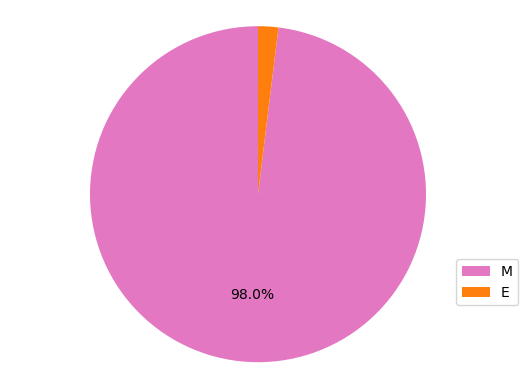

In [43]:
#define initial condition: Mesenchymal cells (EMT drivers high, MET drivers low, TGFB_L ON, BMP OFF, GF OFF)
i_condition_m = model.copy()
maboss.set_nodes_istate(i_condition_m , i_condition_m.network.keys(), random)
maboss.set_nodes_istate(i_condition_m, EMT_drivers, high)
maboss.set_nodes_istate(i_condition_m, MET_drivers, low)
i_condition_m.network.set_istate("TGFB_L", on)
i_condition_m.network.set_istate("GF", off)
i_condition_m.network.set_istate("BMP", off)
maboss.set_output(i_condition_m, phenotypes)

df= multiple_mutations(i_condition_m, mutations, phenotypes)
df.to_csv('specific_mutations_mesenchymalcells_externalTGFBL.txt', index=False)

Mesenchymal cells under GF and TGFB_L

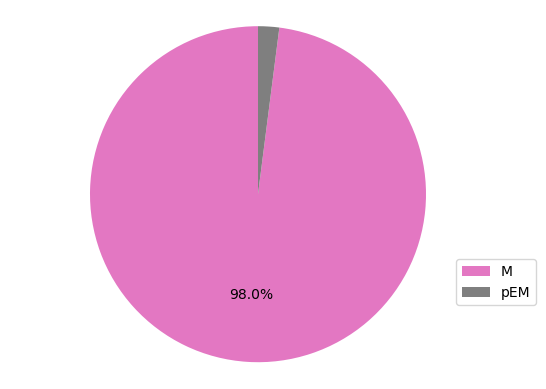

In [44]:
#define initial condition
i_condition_m = model.copy()
maboss.set_nodes_istate(i_condition_m , i_condition_m.network.keys(), random)
maboss.set_nodes_istate(i_condition_m, EMT_drivers, high)
maboss.set_nodes_istate(i_condition_m, MET_drivers, low)
i_condition_m.network.set_istate("TGFB_L", on)
i_condition_m.network.set_istate("GF", on)
i_condition_m.network.set_istate("BMP", off)
maboss.set_output(i_condition_m, phenotypes)

df= multiple_mutations(i_condition_m, mutations, phenotypes)
df.to_csv('specific_mutations_mesenchymalcells_TGFBL_GF.txt', index=False) 

Mesenchymal cells under GF 

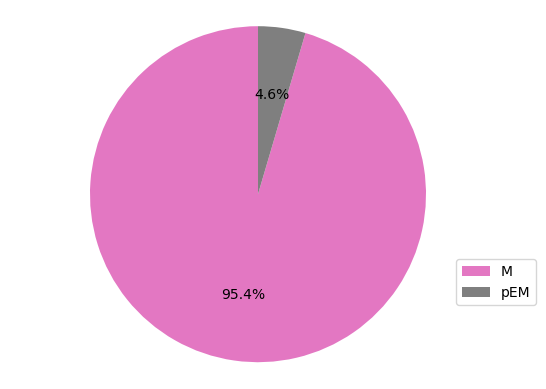

In [45]:
#define initial condition
i_condition_m = model.copy()
maboss.set_nodes_istate(i_condition_m , i_condition_m.network.keys(), random)
maboss.set_nodes_istate(i_condition_m, EMT_drivers, high)
maboss.set_nodes_istate(i_condition_m, MET_drivers, low)
i_condition_m.network.set_istate("TGFB_L", off)
i_condition_m.network.set_istate("GF", on)
i_condition_m.network.set_istate("BMP", off)
maboss.set_output(i_condition_m, phenotypes)

df= multiple_mutations(i_condition_m, mutations, phenotypes)
df.to_csv('specific_mutations_mesenchymalcells_GF.txt', index=False) 

Mesenchymal cells indenpendent of external TGFB_L

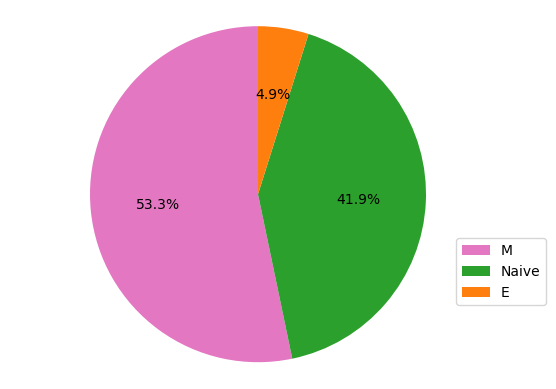

In [46]:
#define initial condition
i_condition_m = model.copy()
maboss.set_nodes_istate(i_condition_m , i_condition_m.network.keys(), random)
maboss.set_nodes_istate(i_condition_m, EMT_drivers, high)
maboss.set_nodes_istate(i_condition_m, MET_drivers, low)
i_condition_m.network.set_istate("TGFB_L", off)
i_condition_m.network.set_istate("GF", off)
i_condition_m.network.set_istate("BMP", off)
maboss.set_output(i_condition_m, phenotypes)

df= multiple_mutations(i_condition_m, mutations, phenotypes)
df.to_csv('specific_mutations_mesenchymalcells_no_external_TGFBL.txt', index=False) 

### Mutations in initial condition that leads cells to a mesenchymal state (MesIC)
Mutations correspond to forced activation or inactivation of nodes in the regulatory network. There is evidence that overpression of some MET-drivers can induce MET in mesenchymal cells and/or prevent EMT from ocurring. 

First, we mutate all the internal nodes, either an activating or inactivating mutation, one at a time on MesIC. 

In [56]:
all_intnodes_mutON = {}
all_intnodes_mutOFF = {}
for node in int_nodes:
    all_intnodes_mutON [node] = {node : 'ON'}
    all_intnodes_mutOFF [node ] = {node : 'OFF'}

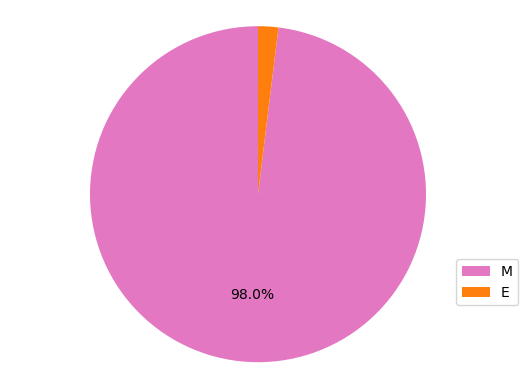

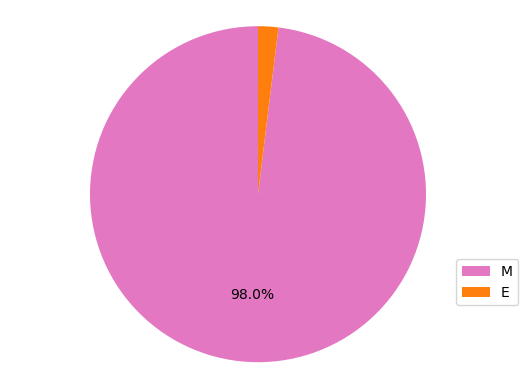

In [58]:
#define initial condition for orginial model
i_condition = model.copy()
maboss.set_nodes_istate(i_condition , i_condition.network.keys(), random)
maboss.set_nodes_istate(i_condition , EMT_drivers, high)
maboss.set_nodes_istate(i_condition , MET_drivers, low)
i_condition.network.set_istate("TGFB_L", on)
i_condition.network.set_istate("GF", off)
i_condition.network.set_istate("BMP", off)
maboss.set_output(i_condition, phenotypes)

#df= multiple_mutations(i_condition, all_intnodes_mut_ON, phenotypes)
df.to_csv('originalmodel_ON_mutations_intnodes.txt', index=False) 

df= multiple_mutations(i_condition, all_intnodes_mutON, phenotypes)
df.to_csv('MesIC_MutationType_ON.txt', index=False) 

df= multiple_mutations(i_condition, all_intnodes_mutOFF, phenotypes)
df.to_csv('MesIC_MutationType_OFF.txt', index=False) 

Analysis of SNAI2 KO mutation

In [68]:
i_condition = model.copy()
maboss.set_nodes_istate(i_condition , i_condition.network.keys(), random)
maboss.set_nodes_istate(i_condition , EMT_drivers, high)
maboss.set_nodes_istate(i_condition , MET_drivers, low)
i_condition.network.set_istate("TGFB_L", on)
i_condition.network.set_istate("GF", off)
i_condition.network.set_istate("BMP", off)
maboss.set_output(i_condition, readouts+phenotypes)

#simulations -> set output for mutant
i_condition.mutate("SNAI2", "OFF")
res = i_condition.run(cmaboss=True)
res.plot_piechart()

plt.title("MesIC - SNAI2 KO")
plt.savefig(f"{path}SNAI2_KO.png", bbox_inches='tight')
plt.close()